In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33427/status,
Dashboard: /proxy/33427/status,Workers: 5
Total threads: 20,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34539,Workers: 5
Dashboard: /proxy/33427/status,Total threads: 20
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:33933,Total threads: 4
Dashboard: /proxy/45987/status,Memory: 25.60 GiB
Nanny: tcp://127.0.0.1:37525,


In [6]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice  = slice(-80,-59)

In [4]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC015/']

cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC015


0it [00:00, ?it/s]


0

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [6]:
# Import salinity

In [7]:
salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [8]:
salt_con = salt_con[:,34:43,:,:]
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade[:,34:43,:,:]
diff_salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade - salt_Tfreezing_min_calv_2

In [9]:
salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2[:,34:43,:,:]
diff_salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2 - salt_con

In [10]:
avek_salt_con = salt_con.mean('st_ocean')
avek_salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.mean('st_ocean')
avek_diff_salt_Tfreezing_min_calv_2 = diff_salt_Tfreezing_min_calv_2.mean('st_ocean')
avek_diff_salt_Tfreezing_min_calv_2_gade = diff_salt_Tfreezing_min_calv_2_gade.mean('st_ocean')

In [11]:
avet_avek_salt_con = avek_salt_con.mean('time')
avet_avek_salt_Tfreezing_min_calv_2 = avek_salt_Tfreezing_min_calv_2.mean('time')
avet_avek_diff_salt_Tfreezing_min_calv_2 = avek_diff_salt_Tfreezing_min_calv_2.mean('time')
avet_avek_diff_salt_Tfreezing_min_calv_2_gade = avek_diff_salt_Tfreezing_min_calv_2_gade.mean('time')

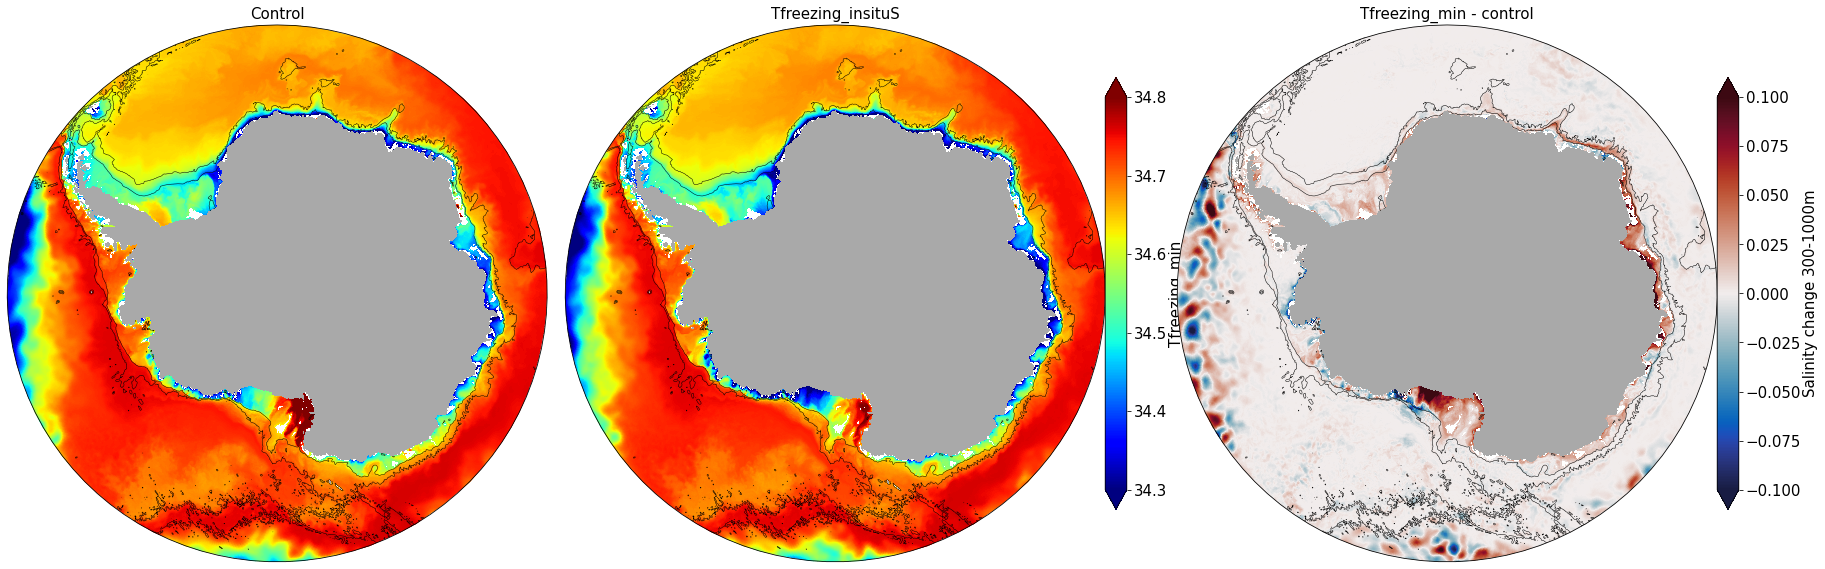

In [12]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_salt_con, vmin=34.3,vmax=34.8,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_salt_Tfreezing_min_calv_2, vmin=34.3,vmax=34.8,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.61, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Tfreezing_min',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min diff
ax = fig.add_axes([0.65, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.95, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salinity change 300-1000m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [13]:
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [14]:
temp_con = temp_con[:,34:43,:,:]
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2[:,34:43,:,:]
diff_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2 - temp_con

avek_diff_temp_Tfreezing_min_calv_2 = diff_temp_Tfreezing_min_calv_2.mean('st_ocean')
avet_avek_diff_temp_Tfreezing_min_calv_2 = avek_diff_temp_Tfreezing_min_calv_2.mean('time')

In [15]:
avek_temp_con = temp_con.mean('st_ocean')
avek_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.mean('st_ocean')

In [9]:
avet_avek_temp_con = avek_temp_con.mean('time')
avet_avek_temp_Tfreezing_min_calv_2 = avek_temp_Tfreezing_min_calv_2.mean('time')

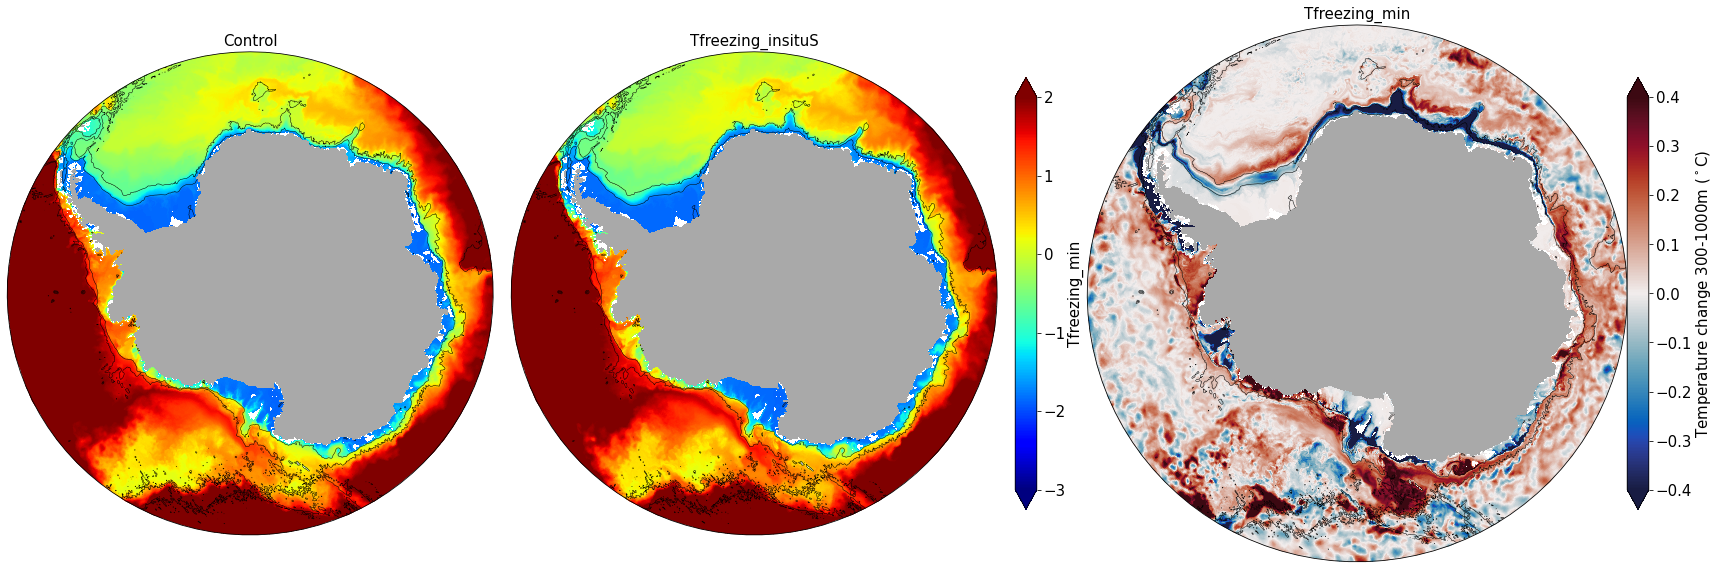

In [10]:
scale_max = .4

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_temp_con, vmin=-3,vmax=2,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.28, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_temp_Tfreezing_min_calv_2, vmin=-3,vmax=2,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.56, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Tfreezing_min',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Difference
ax = fig.add_axes([0.6, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.9, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change 300-1000m ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [17]:
#Age

In [7]:
age_con = cc.querying.getvar(control, 'age_global', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23406243772224 and this is thread id 23403339519744.
Exception closing connection <sqlite3.Connection object at 0x154901a5b3f0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

In [8]:
diff_age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2[:,34:43,:,:] - age_con[:,34:43,:,:]
diff_age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade[:,34:43,:,:] - age_con[:,34:43,:,:]

avek_diff_age_Tfreezing_min_calv_2 = diff_age_Tfreezing_min_calv_2.mean('st_ocean')
avek_diff_age_Tfreezing_min_calv_2_gade = diff_age_Tfreezing_min_calv_2_gade.mean('st_ocean')

avet_avek_diff_age_Tfreezing_min_calv_2 = avek_diff_age_Tfreezing_min_calv_2.mean('time')
avet_avek_diff_age_Tfreezing_min_calv_2_gade = avek_diff_age_Tfreezing_min_calv_2_gade.mean('time')

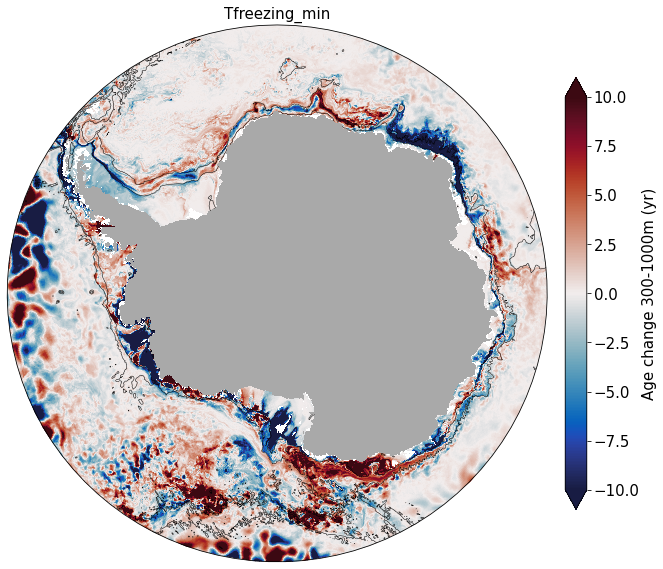

In [9]:
scale_max = 10

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_age_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Age change 300-1000m (yr)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [22]:
#### 44 to 51

In [6]:
salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [7]:
salt_con = salt_con[:,42:47,:,:]
salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2[:,44:51,:,:]
diff_salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2 - salt_con

In [8]:
avek_salt_con = salt_con.mean('st_ocean')
avek_salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.mean('st_ocean')
avek_diff_salt_Tfreezing_min_calv_2 = diff_salt_Tfreezing_min_calv_2.mean('st_ocean')

In [9]:
avet_avek_salt_con = avek_salt_con.mean('time')
avet_avek_salt_Tfreezing_min_calv_2 = avek_salt_Tfreezing_min_calv_2.mean('time')
avet_avek_diff_salt_Tfreezing_min_calv_2 = avek_diff_salt_Tfreezing_min_calv_2.mean('time')

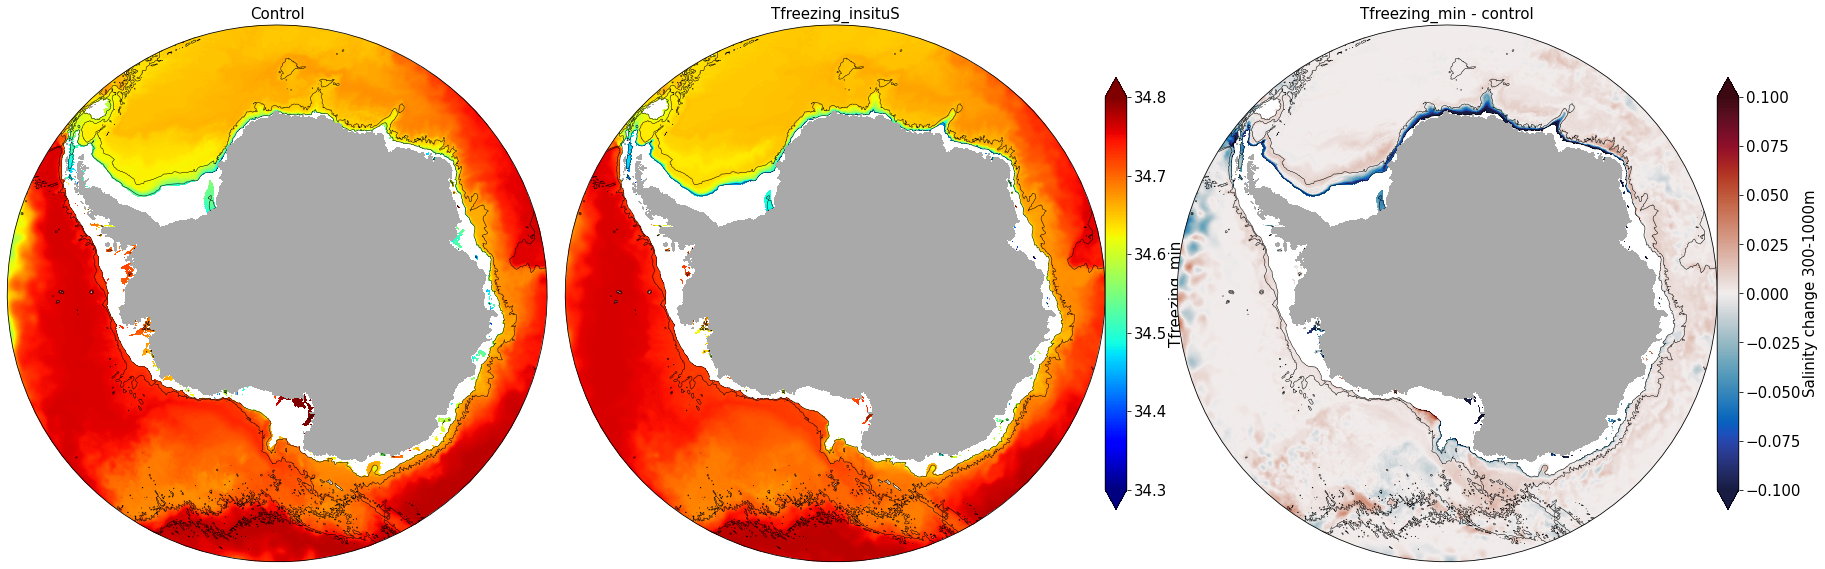

In [10]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_salt_con, vmin=34.3,vmax=34.8,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_salt_Tfreezing_min_calv_2, vmin=34.3,vmax=34.8,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.61, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Tfreezing_min',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min diff
ax = fig.add_axes([0.65, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_salt_Tfreezing_min_calv_2, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.95, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salinity change 300-1000m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [11]:
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [12]:
temp_con = temp_con[:,42:47,:,:]
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2[:,44:51,:,:]
diff_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2 - temp_con

avek_diff_temp_Tfreezing_min_calv_2 = diff_temp_Tfreezing_min_calv_2.mean('st_ocean')
avet_avek_diff_temp_Tfreezing_min_calv_2 = avek_diff_temp_Tfreezing_min_calv_2.mean('time')

In [13]:
avek_temp_con = temp_con.mean('st_ocean')
avek_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.mean('st_ocean')

In [14]:
avet_avek_temp_con = avek_temp_con.mean('time')
avet_avek_temp_Tfreezing_min_calv_2 = avek_temp_Tfreezing_min_calv_2.mean('time')

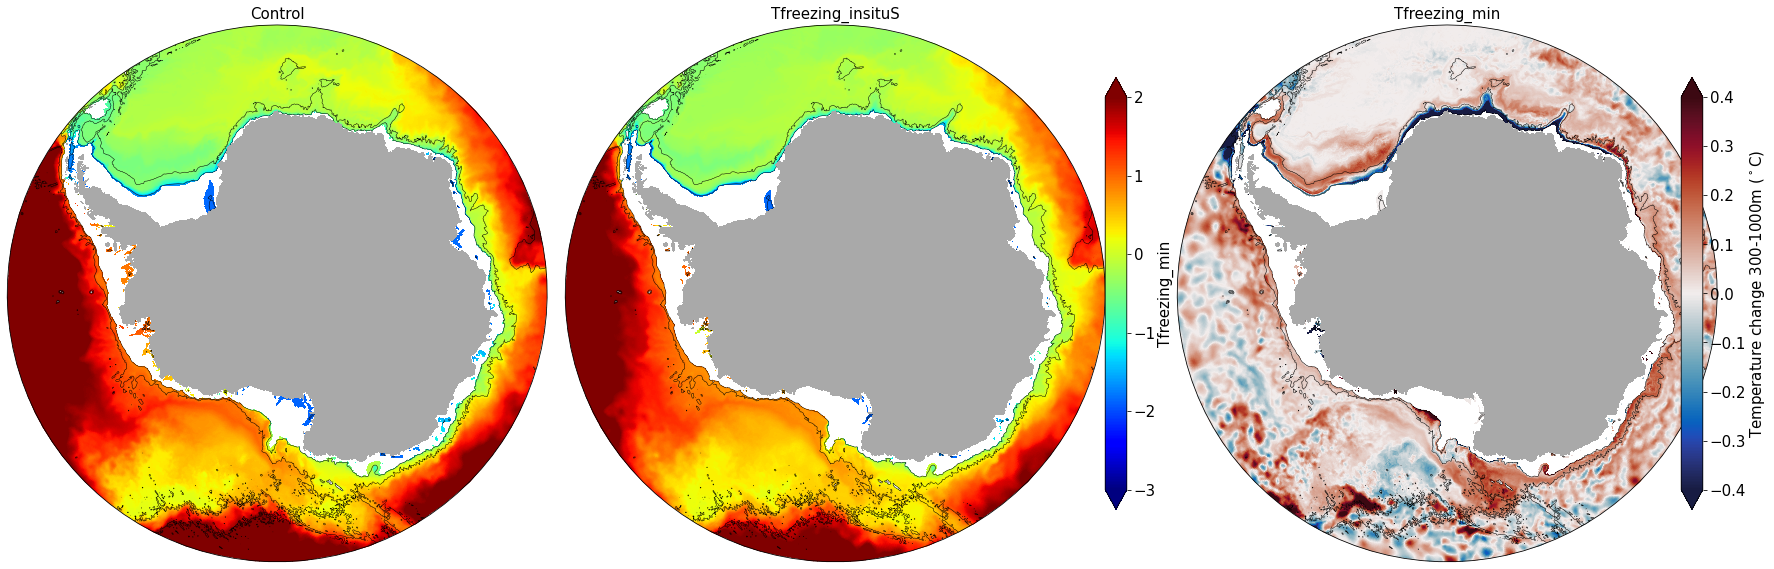

In [15]:
scale_max = .4

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_temp_con, vmin=-3,vmax=2,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

## plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_temp_Tfreezing_min_calv_2, vmin=-3,vmax=2,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.61, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Tfreezing_min',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Difference
ax = fig.add_axes([0.65, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_temp_Tfreezing_min_calv_2, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change 300-1000m ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [16]:
#Age

In [17]:
age_con = cc.querying.getvar(control, 'age_global', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [18]:
age_con = age_con[:,42:47,:,:]
age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2[:,44:47,:,:]
diff_age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2 - age_con

avek_diff_age_Tfreezing_min_calv_2 = diff_age_Tfreezing_min_calv_2.mean('st_ocean')
avet_avek_diff_age_Tfreezing_min_calv_2 = avek_diff_age_Tfreezing_min_calv_2.mean('time')

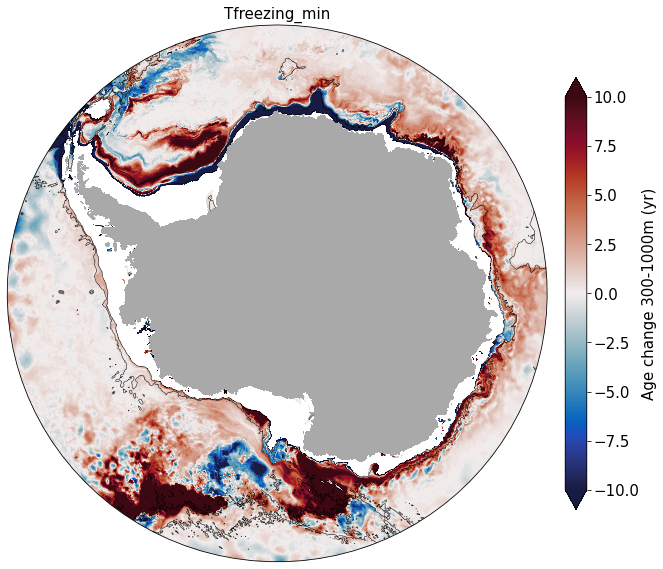

In [19]:
scale_max = 10

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_age_Tfreezing_min_calv_2.xt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2.yt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Age change 300-1000m (yr)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)